In [2]:
!pip install torch_xla[tpu] -f https://storage.googleapis.com/libtpu-releases/index.html


Looking in links: https://storage.googleapis.com/libtpu-releases/index.html


In [3]:
import torch
import torch_xla.core.xla_model as xm
import numpy as np
import time
import csv
from pathlib import Path
import torch_xla

# =========================
# Configuration
# =========================

device = torch_xla.device()

SIZES = {
    "S": 1024,
    "M": 4096,
    "L": 8192,
}

WARMUP = 10
ITERS = 50
DTYPE = torch.float32

POWER_W = {
    "tpu": 75,  # estimation TPU v2/v3
}

RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)
CSV_PATH = RESULTS_DIR / "matmul_tpu.csv"

device = xm.xla_device()

# =========================
# Stats utils
# =========================

def compute_stats(times_ms):
    t = np.array(times_ms)
    return {
        "mean_ms": t.mean(),
        "p50_ms": np.percentile(t, 50),
        "p95_ms": np.percentile(t, 95),
    }

def gflops(n, ms):
    flops = 2 * (n ** 3)
    return flops / (ms / 1000) / 1e9

def energy_j(power, ms):
    return power * (ms / 1000)

# =========================
# Benchmark TPU
# =========================

def bench_tpu(n):
    x = torch.rand((n, n), dtype=DTYPE, device=device)
    y = torch.rand((n, n), dtype=DTYPE, device=device)

    # Warmup
    for _ in range(WARMUP):
        out = torch.mm(x, y)
        torch_xla.sync()
        _ = out.cpu()

    times = []

    for _ in range(ITERS):
        start = time.perf_counter()

        out = torch.mm(x, y)
        torch_xla.sync()
        _ = out.cpu()   # vraie synchronisation

        end = time.perf_counter()
        times.append((end - start) * 1000)

    stats = compute_stats(times)
    stats["gflops"] = gflops(n, stats["mean_ms"])
    stats["energy_j"] = energy_j(POWER_W["tpu"], stats["mean_ms"])

    return stats

# =========================
# CSV save
# =========================

def save_row(size_tag, n, stats):
    exists = CSV_PATH.exists()

    with open(CSV_PATH, "a", newline="") as f:
        w = csv.writer(f)

        if not exists:
            w.writerow([
                "device", "size", "N",
                "mean_ms", "p50_ms", "p95_ms",
                "gflops", "power_w", "energy_j"
            ])

        w.writerow([
            "tpu", size_tag, n,
            stats["mean_ms"], stats["p50_ms"], stats["p95_ms"],
            stats["gflops"], POWER_W["tpu"], stats["energy_j"]
        ])

# =========================
# Main
# =========================

def main():
    print("TPU device:", device)

    for tag, n in SIZES.items():
        print(f"\n=== Size {tag} (N={n}) ===")

        stats = bench_tpu(n)
        print("TPU:", stats)

        save_row(tag, n, stats)

if __name__ == "__main__":
    main()


/tmp/ipython-input-2005435833.py:33: DeprecationWarning: Use torch_xla.device instead
  device = xm.xla_device()


TPU device: xla:0

=== Size S (N=1024) ===
TPU: {'mean_ms': np.float64(4.440941360003308), 'p50_ms': np.float64(1.3769199999842385), 'p95_ms': np.float64(2.843205500005297), 'gflops': np.float64(483.5649638027196), 'energy_j': np.float64(0.3330706020002481)}

=== Size M (N=4096) ===
TPU: {'mean_ms': np.float64(47.61317898000016), 'p50_ms': np.float64(47.21860550012025), 'p95_ms': np.float64(58.096088999957374), 'gflops': np.float64(2886.5737683621383), 'energy_j': np.float64(3.5709884235000118)}

=== Size L (N=8192) ===
TPU: {'mean_ms': np.float64(159.23018426), 'p50_ms': np.float64(153.1212609999102), 'p95_ms': np.float64(178.85745895002856), 'gflops': np.float64(6905.17085617797), 'energy_j': np.float64(11.942263819499999)}


In [4]:
import torch
import torch.nn as nn
import torch_xla
import numpy as np
import time
import csv
from pathlib import Path

# =========================
# Configuration
# =========================

BATCH_SIZE = 32
IMAGE_SIZE = 64
WARMUP = 10
ITERS = 50
DTYPE = torch.float32

POWER_W = {"tpu": 75}

RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)
CSV_PATH = RESULTS_DIR / "cnn_tpu.csv"

device = torch_xla.device()

# =========================
# CNN
# =========================

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * (IMAGE_SIZE // 4) ** 2, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# =========================
# Stats
# =========================

def compute_stats(times):
    t = np.array(times)
    return {
        "mean_ms": float(t.mean()),
        "p50_ms": float(np.percentile(t, 50)),
        "p95_ms": float(np.percentile(t, 95)),
    }

def energy_j(power, ms):
    return power * (ms / 1000)

# =========================
# Benchmark TPU
# =========================

def bench_tpu():

    model = SimpleCNN().to(device)
    model.eval()

    x = torch.rand(
        (BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE),
        dtype=DTYPE,
        device=device
    )

    # Warmup
    with torch.no_grad():
        for _ in range(WARMUP):
            out = model(x)
            torch_xla.sync()
            _ = out.cpu()

    times = []

    # Benchmark
    with torch.no_grad():
        for _ in range(ITERS):

            start = time.perf_counter()

            out = model(x)
            torch_xla.sync()
            _ = out.cpu()

            end = time.perf_counter()
            times.append((end - start) * 1000)

    stats = compute_stats(times)
    stats["energy_j"] = energy_j(POWER_W["tpu"], stats["mean_ms"])

    return stats

# =========================
# CSV save
# =========================

def save_row(stats):

    exists = CSV_PATH.exists()

    with open(CSV_PATH, "a", newline="") as f:
        w = csv.writer(f)

        if not exists:
            w.writerow([
                "device",
                "mean_ms", "p50_ms", "p95_ms",
                "energy_j"
            ])

        w.writerow([
            "tpu",
            stats["mean_ms"],
            stats["p50_ms"],
            stats["p95_ms"],
            stats["energy_j"],
        ])

# =========================
# Main
# =========================

def main():

    print("=== CNN TPU Benchmark ===")
    print("Device:", device)

    stats = bench_tpu()

    print("TPU:", stats)
    save_row(stats)

if __name__ == "__main__":
    main()


=== CNN TPU Benchmark ===
Device: xla:0
TPU: {'mean_ms': 0.8939168599772529, 'p50_ms': 0.8992349999061844, 'p95_ms': 1.0300874998733889, 'energy_j': 0.06704376449829397}


In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import time

# TPU support (optional)
try:
    import torch_xla
    import torch_xla.core.xla_model as xm
    TPU_AVAILABLE = True
except:
    TPU_AVAILABLE = False

# =========================
# CONFIG — tune to stress hardware
# =========================

BATCH_SIZE = 128      # increase to stress more
IMAGE_SIZE = 224
WARMUP = 10
ITERS = 50
DTYPE = torch.float32

# =========================
# Device selection
# =========================

if TPU_AVAILABLE:
    device = torch_xla.device()
    device_type = "TPU"
elif torch.cuda.is_available():
    device = "cuda"
    device_type = "GPU"
else:
    device = "cpu"
    device_type = "CPU"

print("Running on:", device_type)

# =========================
# Model
# =========================

model = models.resnet50(weights=None).to(device)
model.eval()

# heavy input tensor
x_cpu = torch.rand(
    (BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE),
    dtype=DTYPE
)

if device_type == "GPU":
    x = x_cpu.pin_memory().to(device, non_blocking=True)
elif device_type == "TPU":
    x = x_cpu.to(device)
else:
    x = x_cpu

# =========================
# Sync helpers
# =========================

def sync(out=None):
    if device_type == "GPU":
        torch.cuda.synchronize()

    elif device_type == "TPU":
        torch_xla.sync()
        if out is not None:
            _ = out.cpu()

# =========================
# Warmup
# =========================

with torch.no_grad():
    for _ in range(WARMUP):
        out = model(x)
        sync(out)

# =========================
# Benchmark loop
# =========================

times = []

with torch.no_grad():
    for _ in range(ITERS):

        start = time.perf_counter()

        out = model(x)
        sync(out)

        end = time.perf_counter()
        times.append(end - start)

# =========================
# Results
# =========================

times = np.array(times)

latency_ms = times.mean() * 1000
throughput = BATCH_SIZE / times.mean()

print("\n=== STRESS RESULTS ===")
print(f"Mean latency: {latency_ms:.2f} ms / batch")
print(f"Throughput:   {throughput:.0f} images/sec")
print(f"P95 latency:  {np.percentile(times,95)*1000:.2f} ms")


Running on: TPU

=== STRESS RESULTS ===
Mean latency: 23.18 ms / batch
Throughput:   5521 images/sec
P95 latency:  23.95 ms


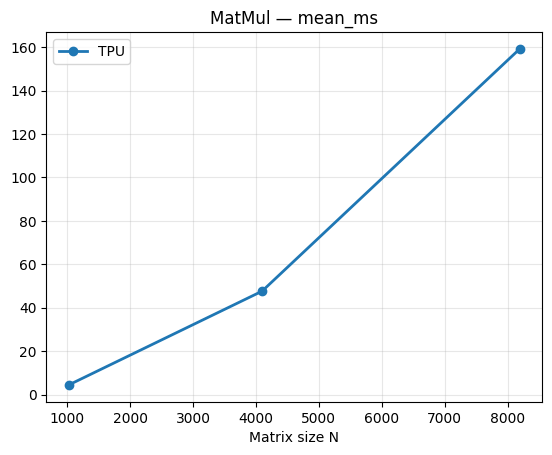

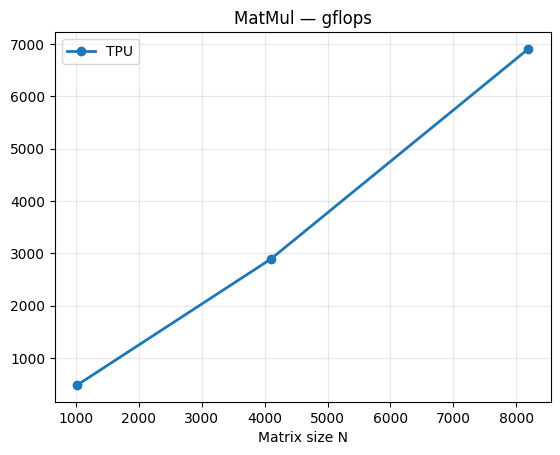

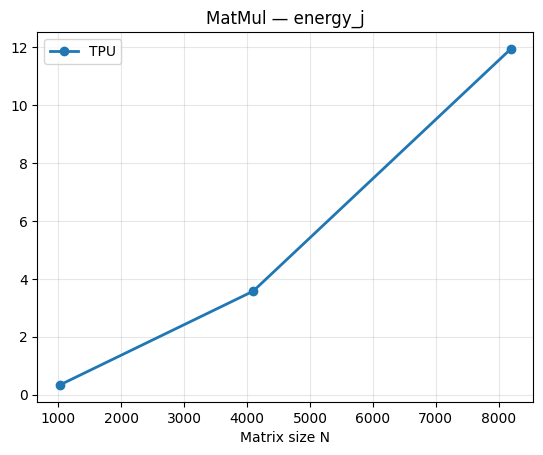

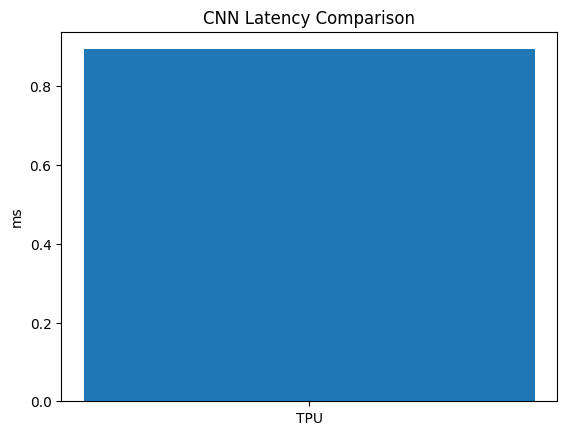

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger données
matmul = pd.read_csv("results/matmul_tpu.csv")
cnn = pd.read_csv("results/cnn_tpu.csv")

# ---------- MatMul Latence ----------

metrics = ["mean_ms", "gflops", "energy_j"]

for metric in metrics:

    plt.figure()

    # Get unique devices from the matmul DataFrame
    available_devices_matmul = matmul["device"].unique()

    for device in available_devices_matmul:

        d = matmul[matmul.device == device].copy()

        # 🔥 TRI IMPORTANT
        d = d.sort_values("N")

        plt.plot(
            d["N"],
            d[metric],
            marker="o",
            linewidth=2,
            label=device.upper()
        )

    plt.title(f"MatMul — {metric}")
    plt.xlabel("Matrix size N")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

# ---------- CNN ----------
plt.figure()

# Get unique devices from the cnn DataFrame
available_devices_cnn = cnn["device"].unique()
labels = [d.upper() for d in available_devices_cnn]
lat = []

for device_name in available_devices_cnn:
    latency_value = cnn[cnn.device == device_name]["mean_ms"].values[0]
    lat.append(latency_value)

plt.bar(labels, lat)
plt.title("CNN Latency Comparison")
plt.ylabel("ms")
plt.show()
